<font size="5"> Perspective transformation </font>

In [41]:
import numpy as np
import cv2
import math

def process_image(image_path, output_path):
    # Read input image and get corners of aruco
    img = cv2.imread(image_path)
    parameters = cv2.aruco.DetectorParameters()
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_36h11)
    corners, _, _ = cv2.aruco.detectMarkers(img, aruco_dict, parameters=parameters)

    if len(corners) == 0:
        print(f"No markers found in {image_path}. Skipping.")
        return

    hh, ww = img.shape[:2]

    # Specify input coordinates for corners of detected marker
    input = np.float32(corners[0][0])

    # Output dimensions and coordinates
    width, height = 150, 150 # Physical dimensions
    output = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

    # Compute perspective matrix
    matrix = cv2.getPerspectiveTransform(input, output)

    # Calculate transformed coordinates and bounding box
    original_corners = np.float32([[0, 0], [ww - 1, 0], [ww - 1, hh - 1], [0, hh - 1] ])
    transformed_corners = cv2.perspectiveTransform(np.array([original_corners]), matrix)[0]
    min_x, max_x = np.min(transformed_corners[:, 0]), np.max(transformed_corners[:, 0])
    min_y, max_y = np.min(transformed_corners[:, 1]), np.max(transformed_corners[:, 1])
    bbox_width, bbox_height = int(np.ceil(max_x - min_x)), int(np.ceil(max_y - min_y))

    # Translation matrix and final transformation
    translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    final_matrix = translation_matrix.dot(matrix)

    # Apply transformation and save result
    output_size = (bbox_width, bbox_height)
    imgOutput = cv2.warpPerspective(img, final_matrix, output_size, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    # Display the result
    cv2.namedWindow("Output Image", cv2.WINDOW_NORMAL)
    cv2.imshow("Output Image", imgOutput)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output image
    cv2.imwrite(output_path, imgOutput)

In [42]:
# List of image paths
image_paths = ["/home/d8/Work/Master_Project/Images/1.jpg", "/home/d8/Work/Master_Project/Images/2.jpg",
              "/home/d8/Work/Master_Project/Images/3.jpg", "/home/d8/Work/Master_Project/Images/4.jpg"]
output_paths = ['/home/d8/Work/Master_Project/Images/11.jpg', "/home/d8/Work/Master_Project/Images/22.jpg",
               '/home/d8/Work/Master_Project/Images/33.jpg', "/home/d8/Work/Master_Project/Images/44.jpg"]

In [43]:
for img_path, out_path in zip(image_paths, output_paths):
    process_image(img_path, out_path)

<font size="5"> Preprocessing images </font>

In [44]:
import cv2
import numpy as np

def process_image_pairs(image_paths, image_paths1, corner_index=0):
    def detect_marker_with_corner(image, corner_index):
        img_height, img_width = image.shape[:2]
        ARUCO_DICT = cv2.aruco.DICT_APRILTAG_36h11
        arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
        arucoParams = cv2.aruco.DetectorParameters()
        corners, ids, rejected = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

        image_corners = {
            'top-left': [0, 0],
            'top-right': [img_width - 1, 0],
            'bottom-left': [0, img_height - 1],
            'bottom-right': [img_width - 1, img_height - 1]
        }

        if ids is not None:
            min_distance = float('inf')
            closest_corner_label = None
            closest_marker_corner = None
            closest_image_corner = None

            for marker_corners in corners:
                corner = marker_corners[0][corner_index]
                for label, image_corner in image_corners.items():
                    distance = np.linalg.norm(corner - np.array(image_corner))
                    if distance < min_distance:
                        min_distance = distance
                        closest_corner_label = label
                        closest_marker_corner = corner
                        closest_image_corner = image_corner

            return closest_corner_label, closest_marker_corner, closest_image_corner, min_distance

        return None, None, None, None

    def rotate_image(image, angle):
        if angle == 0:
            return image
        elif angle == 90:
            return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            return cv2.rotate(image, cv2.ROTATE_180)
        elif angle == 270:
            return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

    def find_shortest_distance_to_corner(image, target_corner_label, corner_index):
        img_height, img_width = image.shape[:2]
        ARUCO_DICT = cv2.aruco.DICT_APRILTAG_36h11
        arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
        arucoParams = cv2.aruco.DetectorParameters()
        corners, ids, rejected = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

        image_corners = {
            'top-left': np.array([0, 0]),
            'top-right': np.array([img_width - 1, 0]),
            'bottom-left': np.array([0, img_height - 1]),
            'bottom-right': np.array([img_width - 1, img_height - 1])
        }

        if ids is not None:
            min_distance = float('inf')
            closest_marker_corner = None
            closest_image_corner = None

            for marker_corners in corners:
                corner = marker_corners[0][corner_index]
                distance = np.linalg.norm(corner - image_corners[target_corner_label])
                if distance < min_distance:
                    min_distance = distance
                    closest_marker_corner = corner
                    closest_image_corner = image_corners[target_corner_label]

            return min_distance, closest_marker_corner, closest_image_corner
        return None, None, None

    # Process each pair of images
    for i in range(len(image_paths)):
        image_path = image_paths[i]
        image_path1 = image_paths1[i]
        
        # Load the images
        image = cv2.imread(image_path)
        image1 = cv2.imread(image_path1)

        # Step 1: Find the closest corner in image
        closest_corner_label, closest_marker_corner, closest_image_corner, min_distance = detect_marker_with_corner(image, corner_index)
        print(f"Closest corner in {image_path}: {closest_corner_label}")
        if closest_marker_corner is not None:
            print(
                f"Shortest line in {image_path} from marker corner {closest_marker_corner} to image corner '{closest_corner_label}' with distance {min_distance:.2f} pixels.")

        # Step 2: Rotate image_path1 and find the best rotation
        best_angle = None
        shortest_distance = float('inf')
        best_marker_corner = None
        best_image_corner = None

        for angle in [0, 90, 180, 270]:
            rotated_image = rotate_image(image1, angle)
            distance, marker_corner, image_corner = find_shortest_distance_to_corner(rotated_image, closest_corner_label, corner_index)

            if distance is not None and distance < shortest_distance:
                shortest_distance = distance
                best_angle = angle
                best_marker_corner = marker_corner
                best_image_corner = image_corner

        # Step 3: Output the best rotation
        print(f"Best rotation angle for {image_path1}: {best_angle}° to match the closest corner '{closest_corner_label}'")
        if best_marker_corner is not None:
            print(
                f"Shortest line in {image_path1} (rotated) from marker corner {best_marker_corner} to image corner '{closest_corner_label}' with distance {shortest_distance:.2f} pixels.")

            # Save the best rotated image without the line
            if best_angle is not None:
                best_rotated_image = rotate_image(image1, best_angle)
                
                # Create the save path for the rotated image
                save_path = image_path1.replace(".jpg", "_rotated.jpg")
                cv2.imwrite(save_path, best_rotated_image)
                print(f"Saved best rotated image to: {save_path}")


In [45]:
# Example usage
image_paths = ['/home/d8/Work/Master_Project/Images/1.jpg',
               '/home/d8/Work/Master_Project/Images/2.jpg',
               '/home/d8/Work/Master_Project/Images/3.jpg',
              '/home/d8/Work/Master_Project/Images/4.jpg']

image_paths1 = ['/home/d8/Work/Master_Project/Images/11.jpg',
                '/home/d8/Work/Master_Project/Images/22.jpg',
                '/home/d8/Work/Master_Project/Images/33.jpg',
               '/home/d8/Work/Master_Project/Images/44.jpg']

# Call the function to process the images
process_image_pairs(image_paths, image_paths1, corner_index=0) 

Closest corner in /home/d8/Work/Master_Project/Images/1.jpg: top-left
Shortest line in /home/d8/Work/Master_Project/Images/1.jpg from marker corner [ 712. 1808.] to image corner 'top-left' with distance 1943.14 pixels.
Best rotation angle for /home/d8/Work/Master_Project/Images/11.jpg: 0° to match the closest corner 'top-left'
Shortest line in /home/d8/Work/Master_Project/Images/11.jpg (rotated) from marker corner [ 445. 1355.] to image corner 'top-left' with distance 1426.20 pixels.
Saved best rotated image to: /home/d8/Work/Master_Project/Images/11_rotated.jpg
Closest corner in /home/d8/Work/Master_Project/Images/2.jpg: top-left
Shortest line in /home/d8/Work/Master_Project/Images/2.jpg from marker corner [1200.  920.] to image corner 'top-left' with distance 1512.08 pixels.
Best rotation angle for /home/d8/Work/Master_Project/Images/22.jpg: 270° to match the closest corner 'top-left'
Shortest line in /home/d8/Work/Master_Project/Images/22.jpg (rotated) from marker corner [754. 657.]

<font size="5">Get the relative locations between markers</font>


In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_aruco_corners(img_paths, aruco_type):
    ARUCO_DICT = {
        "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
        "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
        "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
        "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
        "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
        "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
        "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
        "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
        "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
        "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
        "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
        "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
        "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
        "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
        "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
        "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
        "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
        "DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
        "DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
        "DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
        "DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
    }

    all_relative_positions = {}

    for img_path in img_paths:
        print("[INFO] Loading image...")
        image = cv2.imread(img_path)

        if image is None:
            print("[ERROR] Image not found or cannot be loaded.")
            continue

        if image.shape[0] > image.shape[1]:
            # Rotate the image 90 degrees counterclockwise
            image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            # image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)


        if ARUCO_DICT.get(aruco_type, None) is None:
            print("[INFO] ArUCo tag of '{}' is not supported".format(aruco_type))
            continue

        print("[INFO] Detecting '{}' tags in {}...".format(aruco_type, img_path))
        arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT[aruco_type])
        arucoParams = cv2.aruco.DetectorParameters()
        (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)
        
        for i, corner in enumerate(corners):
            marker_corners = corner[0]
            marker_centroid = np.mean(marker_corners, axis=0)

            # Draw marker boundaries
            cv2.polylines(image, [marker_corners.astype(np.int32)], True, (0, 255, 0), 2)
            # Draw marker centroid
            cv2.circle(image, tuple(marker_centroid.astype(int)), 5, (0, 0, 255), -1)
            # Draw marker ID
            cv2.putText(image, f"ID: {ids[i][0]}", tuple(marker_centroid.astype(int) + np.array([0, -10])),
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)

        if ids is not None:
            # Find marker 4
            marker4_index = np.where(ids == 4)[0]
            if len(marker4_index) == 0:
                print("Marker 4 not found in {}.".format(img_path))
                continue

            marker4_index = marker4_index[0]
            marker4_corners = corners[marker4_index][0]
            marker4_centroid = np.mean(marker4_corners, axis=0)

            # Calculate relative positions of other markers based on marker 4
            relative_positions = {}
            for i, corner in enumerate(corners):
                if i != marker4_index:
                    marker_corners = corner[0]
                    marker_centroid = np.mean(marker_corners, axis=0)
                    relative_position = marker_centroid - marker4_centroid
                    relative_positions[ids[i][0]] = relative_position.tolist()  # Convert to list for JSON serialization

            all_relative_positions[img_path] = relative_positions
            
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('on')
            plt.show()

            print("Relative positions based on marker 4 in {}: {}".format(img_path, relative_positions))

        else:
            print("No markers detected in {}.".format(img_path))

    return all_relative_positions

In [62]:
img_paths = ["/home/d8/Work/Master_Project/Images/22_rotated.jpg", "/home/d8/Work/Master_Project/Images/33_rotated.jpg"]

In [63]:
aruco_type = "DICT_APRILTAG_36h11"

[INFO] Loading image...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in /home/d8/Work/Master_Project/Images/22_rotated.jpg...


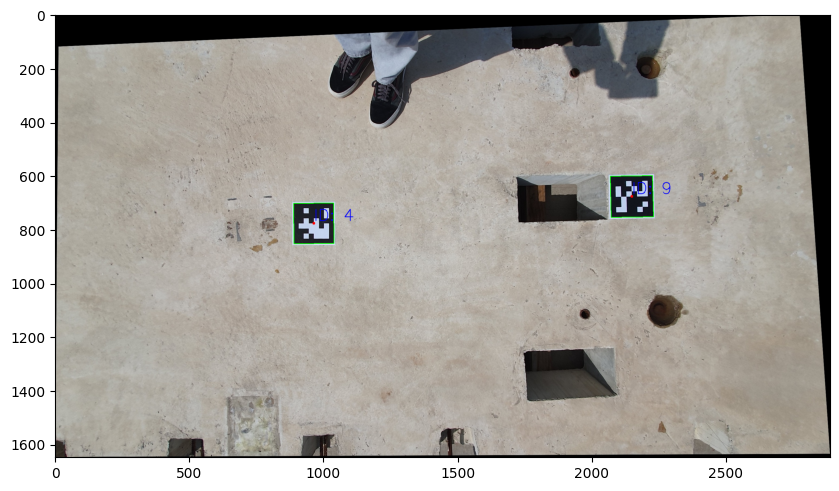

Relative positions based on marker 4 in /home/d8/Work/Master_Project/Images/22_rotated.jpg: {9: [1185.25, -100.0]}
[INFO] Loading image...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in /home/d8/Work/Master_Project/Images/33_rotated.jpg...


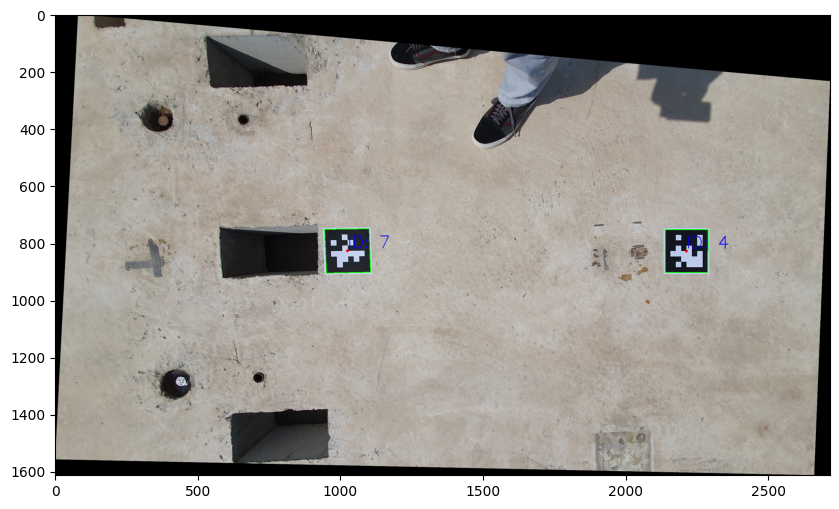

Relative positions based on marker 4 in /home/d8/Work/Master_Project/Images/33_rotated.jpg: {7: [-1188.0, -0.75]}


In [64]:
all_relative_positions = detect_aruco_corners(img_paths, aruco_type)

<font size="5">Get the relative locations between shear pocket and markers</font>

In [50]:
!python3 /home/d8/Work/yolov9/segment/predict.py --source "/home/d8/Work/Master_Project/Images/11_rotated.jpg" --img-size 1600 --device 0 --weights '/home/d8/Work/yolov9/runs/train-seg/gelan-c-pan22/weights/best.pt'

segment/predict: weights=['/home/d8/Work/yolov9/runs/train-seg/gelan-c-pan22/weights/best.pt'], source=/home/d8/Work/Master_Project/Images/11_rotated.jpg, data=../../yolov9/data/coco128.yaml, imgsz=[1600, 1600], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../../yolov9/runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLO 🚀 v0.1-60-g4cf2226 Python-3.11.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 7862MiB)

Fusing layers... 
gelan-c-seg-custom summary: 414 layers, 27362899 parameters, 0 gradients, 144.2 GFLOPs
Detected Shear Pocket center at [781.00, 2084.00]
Detected Shear Pocket center at [771.00, 1427.50]
Detected Shear Pocket center at [757.00, 776.00]
Locations saved to: /home/d8/yolov9/Loca

In [51]:
!python3 /home/d8/Work/yolov9/segment/predict1.py --source '/home/d8/Work/Master_Project/Images/44_rotated.jpg' --img-size 1600 --device 0 --weights '/home/d8/Work/yolov9/runs/train-seg/gelan-c-pan22/weights/best.pt'

segment/predict1: weights=['/home/d8/Work/yolov9/runs/train-seg/gelan-c-pan22/weights/best.pt'], source=/home/d8/Work/Master_Project/Images/44_rotated.jpg, data=../../yolov9/data/coco128.yaml, imgsz=[1600, 1600], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../../yolov9/runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLO 🚀 v0.1-60-g4cf2226 Python-3.11.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 7862MiB)

Fusing layers... 
gelan-c-seg-custom summary: 414 layers, 27362899 parameters, 0 gradients, 144.2 GFLOPs
Detected Shear Pocket center at [927.50, 1514.50]
Detected Shear Pocket center at [922.00, 866.00]
Detected Shear Pocket center at [949.00, 2156.00]
Locations saved to: /home/d8/yolov9/Loc

In [52]:
# Load x-coordinate values from Locations.txt
file_path1 = "/home/d8/yolov9/Locations.txt"
with open(file_path1, "r") as f:
    first_line = f.readline()
    second_line = f.readline()
    third_line = f.readline()
    
# Extract coordinates for the first image
A = (int(float(first_line.strip().split(',')[0])), int(float(first_line.strip().split(',')[1])))
B = (int(float(second_line.strip().split(',')[0])), int(float(second_line.strip().split(',')[1])))
C = (int(float(third_line.strip().split(',')[0])), int(float(third_line.strip().split(',')[1])))

file_path2 = "/home/d8/yolov9/Location.txt"
with open(file_path2, "r") as f:
    first_line = f.readline()
    second_line = f.readline()
    third_line = f.readline()
    
# Extract coordinates for the second image
D = (int(float(first_line.strip().split(',')[0])), int(float(first_line.strip().split(',')[1])))
E = (int(float(second_line.strip().split(',')[0])), int(float(second_line.strip().split(',')[1])))
F = (int(float(third_line.strip().split(',')[0])), int(float(third_line.strip().split(',')[1])))

# Print the coordinates
print("Coordinates for Image 1:")
print("A:", A)
print("B:", B)
print("C:", C)

print("Coordinates for Image 2:")
print("D:", D)
print("E:", E)
print("F:", F)


Coordinates for Image 1:
A: (781, 2084)
B: (771, 1427)
C: (757, 776)
Coordinates for Image 2:
D: (927, 1514)
E: (922, 866)
F: (949, 2156)


<font size="3.5"> Reload Processed images </font>



In [53]:
img_paths1 = ["/home/d8/Work/Master_Project/Images/11_rotated.jpg", "/home/d8/Work/Master_Project/Images/44_rotated.jpg"]

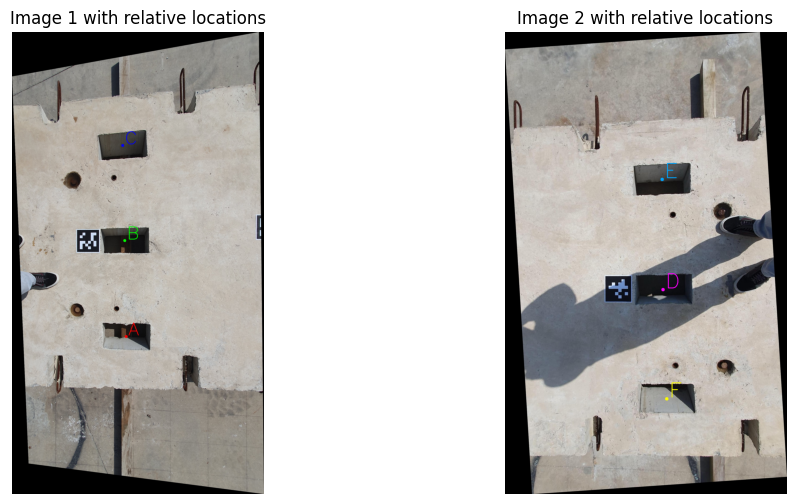

In [54]:
# Read and process the first image
image1 = cv2.imread(img_paths1[0])
# if image1.shape[0] < image1.shape[1]:
#     image1 = cv2.rotate(image1, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Draw circles for points A, B, C on the first image
cv2.circle(image1, A, radius=10, color=(0, 0, 255), thickness=-1)  # Red circle
cv2.circle(image1, B, radius=10, color=(0, 255, 0), thickness=-1)  # Green circle
cv2.circle(image1, C, radius=10, color=(255, 0, 0), thickness=-1)  # Blue circle
cv2.putText(image1, 'A', (A[0] + 15, A[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 0, 255), 4, cv2.LINE_AA)
cv2.putText(image1, 'B', (B[0] + 15, B[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 0), 4, cv2.LINE_AA)
cv2.putText(image1, 'C', (C[0] + 15, C[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 4, cv2.LINE_AA)

# Read and process the second image
image2 = cv2.imread(img_paths1[1])
# if image2.shape[0] < image2.shape[1]:
#     image2 = cv2.rotate(image2, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Draw circles for points D, E, F on the second image
cv2.circle(image2, D, radius=10, color=(255, 0, 255), thickness=-1)  # Red circle
cv2.circle(image2, E, radius=10, color=(255, 165, 0), thickness=-1)  # Green circle
cv2.circle(image2, F, radius=10, color=(0, 255, 255), thickness=-1)  # Blue circle

cv2.putText(image2, 'D', (D[0] + 15, D[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 255), 4, cv2.LINE_AA)
cv2.putText(image2, 'E', (E[0] + 15, E[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 165, 0), 4, cv2.LINE_AA)
cv2.putText(image2, 'F', (F[0] + 15, F[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 255), 4, cv2.LINE_AA)

# Convert BGR images to RGB for Matplotlib
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display images using Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image1_rgb)
plt.title("Image 1 with relative locations")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2_rgb)
plt.title("Image 2 with relative locations")
plt.axis('off')

plt.show()

In [55]:
aruco_type = "DICT_APRILTAG_36h11"

def detect_aruco_corners(img_paths, aruco_type):
    ARUCO_DICT = {
        "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
        "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
        "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
        "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
        "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
        "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
        "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
        "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
        "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
        "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
        "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
        "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
        "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
        "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
        "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
        "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
        "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
        "DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
        "DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
        "DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
        "DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
    }

    if ARUCO_DICT.get(aruco_type, None) is None:
        print(f"[INFO] ArUCo tag of '{aruco_type}' is not supported")
        return None, None

    arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT[aruco_type])
    arucoParams = cv2.aruco.DetectorParameters()

    centroids = []
    for img_path in img_paths:
        print(f"[INFO] Loading image {img_path}...")
        image = cv2.imread(img_path)
        if image is None:
            print(f"[ERROR] Image {img_path} not found or cannot be loaded.")
            continue

        if image.shape[0] < image.shape[1]:
            # Rotate the image 90 degrees counterclockwise
            image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        print(f"[INFO] Detecting '{aruco_type}' tags in {img_path}...")
        corners, ids, _ = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

        if ids is not None:
            for i, corner in enumerate(corners):
                marker_corners = corner[0]
                marker_centroid = np.mean(marker_corners, axis=0)

                # Draw marker boundaries
                cv2.polylines(image, [marker_corners.astype(np.int32)], True, (0, 255, 0), 2)
                # Draw marker centroid
                cv2.circle(image, tuple(marker_centroid.astype(int)), 5, (0, 0, 255), -1)
                # Draw marker ID
                cv2.putText(image, f"ID: {ids[i][0]}", tuple(marker_centroid.astype(int) + np.array([0, -10])),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

#             # Display the image with detected markers
#             plt.figure(figsize=(10, 10))
#             plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#             plt.title(f"Detected ArUco Markers in {img_path}")
#             plt.axis('off')
#             plt.show()

            marker_centroid = np.mean(marker_corners, axis=0)
            centroids.append((marker_centroid, image, corners, ids))
            print(f"Marker found in {img_path} with centroid at {marker_centroid}.")
        else:
            print(f"No markers detected in {img_path}.")

    return centroids


def calculate_relative_positions(centroids):
    if len(centroids) == 2:
        centroid_1, image_1, corners_1, ids_1 = centroids[0]
        centroid_4, image_4, corners_4, ids_4 = centroids[1]

        # Calculate relative positions for A, B, C based on centroid_1
        A_rel = np.array(A) - centroid_1
        B_rel = np.array(B) - centroid_1
        C_rel = np.array(C) - centroid_1

        # Calculate relative positions for D, E, F based on centroid_4
        D_rel = np.array(D) - centroid_4
        E_rel = np.array(E) - centroid_4
        F_rel = np.array(F) - centroid_4

        return (A_rel, B_rel, C_rel), (D_rel, E_rel, F_rel)
    else:
        print("Could not find markers in both images of img_paths1.")
        return None, None

In [56]:
# Detect centroids in the images from img_paths1
centroids1 = detect_aruco_corners(img_paths1, aruco_type)

# Calculate relative positions
rel_positions_1, rel_positions_4 = calculate_relative_positions(centroids1)

if rel_positions_1 and rel_positions_4:
    A_rel, B_rel, C_rel = rel_positions_1
    D_rel, E_rel, F_rel = rel_positions_4

    print(f"Relative positions based on marker in ../Positions/1.jpg:")
    print(f"A_rel: {A_rel}")
    print(f"B_rel: {B_rel}")
    print(f"C_rel: {C_rel}")

    print(f"Relative positions based on marker in ../Positions/4.jpg:")
    print(f"D_rel: {D_rel}")
    print(f"E_rel: {E_rel}")
    print(f"F_rel: {F_rel}")
else:
    print("Error in calculating relative positions.")

[INFO] Loading image /home/d8/Work/Master_Project/Images/11_rotated.jpg...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in /home/d8/Work/Master_Project/Images/11_rotated.jpg...
Marker found in /home/d8/Work/Master_Project/Images/11_rotated.jpg with centroid at [ 520.   1429.25].
[INFO] Loading image /home/d8/Work/Master_Project/Images/44_rotated.jpg...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in /home/d8/Work/Master_Project/Images/44_rotated.jpg...
Marker found in /home/d8/Work/Master_Project/Images/44_rotated.jpg with centroid at [ 664.5 1509.5].
Relative positions based on marker in ../Positions/1.jpg:
A_rel: [261.   654.75]
B_rel: [251.    -2.25]
C_rel: [ 237.   -653.25]
Relative positions based on marker in ../Positions/4.jpg:
D_rel: [262.5   4.5]
E_rel: [ 257.5 -643.5]
F_rel: [284.5 646.5]



<font size="5">Get the final coordinates of shear pockets</font>

In [57]:
first_img_path = img_paths[0]
first_relative_position = all_relative_positions.get(first_img_path, None)
if first_relative_position:
    first_relative_coordinate = next(iter(first_relative_position.values()))
    print("First relative coordinate based on Marker 2 in {}: {}".format(first_img_path, first_relative_coordinate))
else:
    print("No relative positions found for {}".format(first_img_path))

First relative coordinate based on Marker 2 in /home/d8/Work/Master_Project/Images/22_rotated.jpg: [-1185.25, 100.0]


In [58]:
# Final locations A B C
A_final = A_rel + first_relative_coordinate
B_final = B_rel + first_relative_coordinate
C_final = C_rel + first_relative_coordinate

print("Final Location A:", A_final)
print("Final Location B:", B_final)
print( "Final Location C:",C_final)

Final Location A: [-924.25  754.75]
Final Location B: [-934.25   97.75]
Final Location C: [-948.25 -553.25]


In [59]:
second_img_path = img_paths[1]
second_relative_position = all_relative_positions.get(second_img_path, None)
if second_relative_position:
    second_relative_coordinate = next(iter(second_relative_position.values()))
    print("second relative coordinate based on Marker 2 in {}: {}".format(second_img_path, second_relative_coordinate))
else:
    print("No relative positions found for {}".format(second_img_path))

second relative coordinate based on Marker 2 in /home/d8/Work/Master_Project/Images/33_rotated.jpg: [1188.0, 0.75]


In [60]:
# Final locations D E F
D_final = D_rel + second_relative_coordinate
E_final = E_rel + second_relative_coordinate
F_final = F_rel + second_relative_coordinate

print("Final Location D:", D_final)
print("Final Location E:", E_final)
print( "Final Location F:",F_final)

Final Location D: [1450.5     5.25]
Final Location E: [1445.5  -642.75]
Final Location F: [1472.5   647.25]
